In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Mouna_Loa_Weekly_Data.csv')
df_new.head()

,Year,Month,Day,Year(decimal),CO2(PPM)
0,1974,5,19,1974.3795,333.37
1,1974,5,26,1974.3986,332.95
2,1974,6,2,1974.4178,332.35
3,1974,6,9,1974.4370,332.20
4,1974,6,16,1974.4562,332.37


In [4]:
df_new.tail()

,Year,Month,Day,Year(decimal),CO2(PPM)
2472,2021,10,3,2021.7548,413.63
2473,2021,10,10,2021.7740,413.89
2474,2021,10,17,2021.7932,414.36
2475,2021,10,24,2021.8123,413.90
2476,2021,10,31,2021.8315,414.17


In [5]:
df_new.shape

(2477, 5)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           2477 non-null   int64  
 1   Month          2477 non-null   int64  
 2   Day            2477 non-null   int64  
 3   Year(decimal)  2477 non-null   float64
 4   CO2(PPM)       2477 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 96.9 KB


In [6]:
df_new['CO2(PPM)'].min()

-999.99

In [7]:
df_new.replace(-999.99,np.nan,inplace=True)
df = df_new.fillna(df_new.rolling(7,min_periods=1).mean())

In [ ]:
df.isnull().sum()

Year             0
Month            0
Day              0
Year(decimal)    0
CO2(PPM)         0
dtype: int64

In [8]:
time = pd.date_range(start='5/19/1974',periods=2477,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Year','Month','Year(decimal)','Day'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [9]:
df.columns=['CO2_PPM']

In [ ]:
df.head()

,CO2_PPM
time_stamp,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37


In [ ]:
df.tail()

,CO2_PPM
time_stamp,
2021-10-03,413.63
2021-10-10,413.89
2021-10-17,414.36
2021-10-24,413.90
2021-10-31,414.17


In [10]:
plt.rcParams['figure.figsize'] = [15,8]

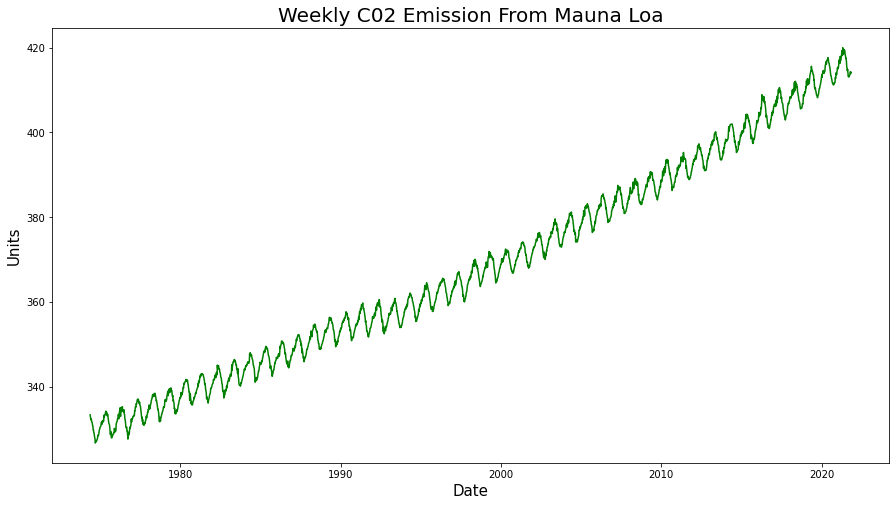

In [11]:
plt.plot(df,color='green')
plt.title('Weekly C02 Emission From Mauna Loa',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [12]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [13]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['CO2_PPM'] = df['CO2_PPM'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [14]:
#Split data set into testing dataset and train dataset
train_size = 2230
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 5
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2225, 1, 5)
(2225,)
(242, 1, 5)
(242,)


In [16]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [17]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer',min_value=4,max_value=96,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.1,0.2,0.3],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=96,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=33,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 42s]
val_mape: 0.4720008075237274

Best val_mape So Far: 0.4720008075237274
Total elapsed time: 00h 08m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 32
first_recurrent_dropout: 0.1
dense_layer: 16
Dropout_rate: 0.0
learning_rate: 0.0032626007343494624
Score: 0.4720008075237274
Trial summary
Hyperparameters:
rnn_layer: 80
first_recurrent_dropout: 0.2
dense_layer: 32
Dropout_rate: 0.30000000000000004
learning_rate: 0.04833503716670173
Score: 0.4786186218261719
Trial summary
Hyperparameters:
rnn_layer: 80
first_recurrent_dropout: 0.1
dense_layer: 52
Dropout_rate: 0.2
learning_rate: 0.03029533978936301
Score: 0.4942636489868164
Trial summary
Hyperparameters:
rnn_layer: 84
first_recurrent_dropout: 0.1
dense_layer: 80
Dropout_rate: 0.30000000000000004
learning_rate: 0.010604459766301734
Score: 0.49488842487335205
Trial summary
Hyperparameters:
rnn_layer: 40
first_recurrent_dropout: 0.1
dense_layer: 80
Dropout_rate: 0.1
learning_rate: 0.005212802935732381
Score: 0.49581480026245117
Trial 

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 5))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [24]:
model = Sequential()
model.add(SimpleRNN(32,activation='relu',input_dim = 5))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.000032626007343494624)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 33, epochs = 400)

Epoch 1/400
68/68 [==============================] - 1s 6ms/step - loss: 81.6041 - mape: 81.6041 - val_loss: 80.1439 - val_mape: 80.1439
Epoch 2/400
68/68 [==============================] - 0s 3ms/step - loss: 76.3414 - mape: 76.3414 - val_loss: 75.9535 - val_mape: 75.9535
Epoch 3/400
68/68 [==============================] - 0s 3ms/step - loss: 70.8899 - mape: 70.8899 - val_loss: 71.7365 - val_mape: 71.7365
Epoch 4/400
68/68 [==============================] - 0s 3ms/step - loss: 65.4931 - mape: 65.4931 - val_loss: 67.5419 - val_mape: 67.5419
Epoch 5/400
68/68 [==============================] - 0s 3ms/step - loss: 60.2195 - mape: 60.2195 - val_loss: 63.3906 - val_mape: 63.3906
Epoch 6/400
68/68 [==============================] - 0s 3ms/step - loss: 55.0820 - mape: 55.0820 - val_loss: 59.2985 - val_mape: 59.2985
Epoch 7/400
68/68 [==============================] - 0s 3ms/step - loss: 50.0512 - mape: 50.0512 - val_loss: 55.2812 - val_mape: 55.2812
Epoch 8/400
68/68 [======================

In [27]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [25]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.56 
Test MAPE : 0.69 


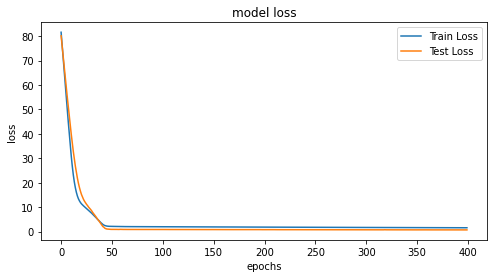

In [28]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [29]:
import seaborn as sns

In [30]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2225,2467)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

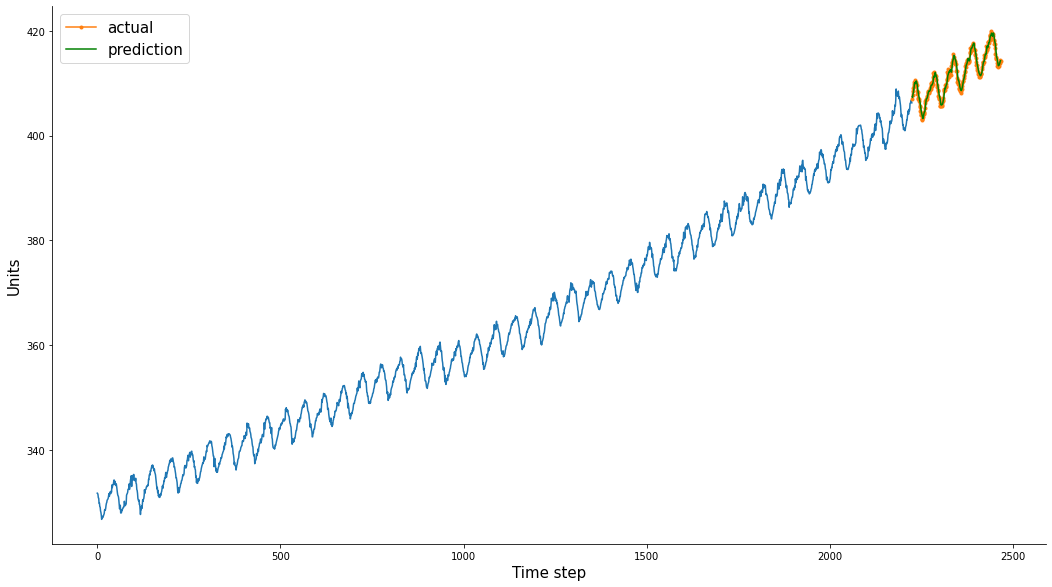

In [31]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)